# Demo of graph optimisation to segment dummy structures

In [1]:
from grace.simulator.simulate_image import synthetic_image_dataset

In [4]:
num_images = 1
motif = "line"
path = "/Users/kulicna/Desktop/classifier/data_fake/infer/padded"

synthetic_image_dataset(num_images=num_images, motif=motif, folder_path=path)

In [6]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import h5py
import mrcfile
from skimage.util import montage


In [7]:
from grace.base import GraphAttrs
from grace.models.optimise import optimise_graph
from grace.simulator.simulate_graph import random_graph, random_graph_mixed_motifs


In [3]:
value = 255
scale = 3500
patch = 224

CROP_SHAPE = (patch, patch)
MASK_SHAPE = tuple([p // 2 for p in CROP_SHAPE])
CROP_SHAPE, MASK_SHAPE

((224, 224), (112, 112))

### Load a dummy graph:

In [4]:
G = random_graph(n_motifs=5, n_chaff=100, scale=scale, density=0.025, motif="line")

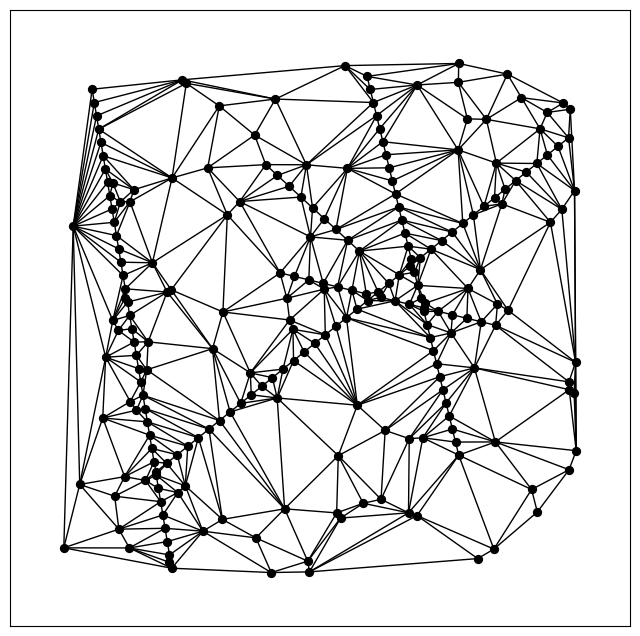

In [5]:
pos = {idx: (node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]) for idx, node in G.nodes(data=True)}
fig, ax = plt.subplots(figsize=(8, 8))

# draw all nodes/vertices in the graph, including those not determined to be part of the objects
nx.draw_networkx(G, ax=ax, pos=pos, with_labels=False, node_color="k", node_size=32)

In [6]:
coords = np.array([[node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]] for _, node in G.nodes(data=True)])
coords.shape, coords[0].min(), coords[0].max(), coords[1].min(), coords[1].max()

((233, 2),
 982.1167509401824,
 2165.0902972768567,
 489.29415658806323,
 2630.622911196346)

### Update the graph with bimodal node & edge predictions:

In [7]:
# # NOTE(arl): this is *super* hacky - just to see if the optimisation works

# def update_graph_dummy_predictions(G: nx.Graph):

#     nodes = list(G.nodes.data())

#     for _, node in nodes:
#         pd = np.random.random() * 0.5
#         if node["label"] > 0:
#             node[GraphAttrs.NODE_PREDICTION] = pd
#         else:
#             node[GraphAttrs.NODE_PREDICTION] = 1-pd

    
#     for edge in G.edges.data():
#         pd = np.random.random() * 0.1
#         _, e_i = nodes[edge[0]]
#         _, e_j = nodes[edge[1]]
        
#         if e_i["object_idx"] == e_j["object_idx"] and e_i["label"] > 0:
#             edge[2][GraphAttrs.EDGE_PREDICTION] = 1 - pd
#         else:
#             edge[2][GraphAttrs.EDGE_PREDICTION] = pd 


In [8]:
update_graph_dummy_predictions(G)


### Update the coords by the padding:

In [10]:
def update_graph_coords_by_pad(G: nx.Graph, padding_width: tuple[int, int]):

    for _, node in G.nodes(data=True):
        node[GraphAttrs.NODE_X] += padding_width[0]
        node[GraphAttrs.NODE_Y] += padding_width[1]
        

In [11]:
update_graph_coords_by_pad(G=G, padding_width=CROP_SHAPE)


### Synthesize a fake image:

In [12]:
# def create_blank_image(image_value: float, image_shape: tuple[int, int], image_padding: tuple[int, int] = None):
#     image = np.zeros(shape=image_shape, dtype=np.float32)
#     image += image_value
#     if image_padding is not None: 
#         image = np.pad(image, pad_width=image_padding, mode='constant', constant_values=image_value)
#     return image


In [15]:
image = create_blank_image(image_value=value, image_shape=(scale, scale), image_padding=CROP_SHAPE)
image.shape, image.dtype, image[0, 0]

((3948, 3948), dtype('float32'), 255.0)

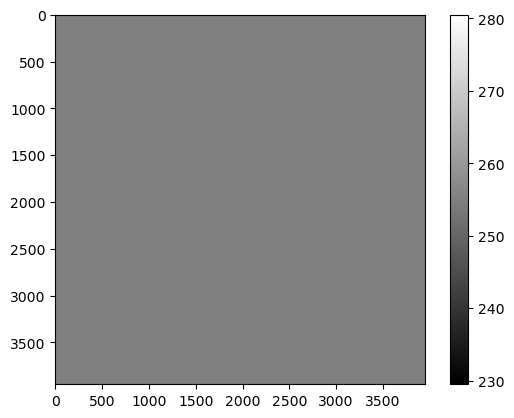

In [16]:
plt.imshow(image, cmap='binary_r')
plt.colorbar()
plt.show()

### Project the nodes into the image:

In [17]:
coords = np.array([[node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]] for _, node in G.nodes(data=True)])
coords.shape, coords[0].min(), coords[0].max(), coords[1].min(), coords[1].max()

((233, 2),
 1206.1167509401826,
 2389.0902972768567,
 713.2941565880633,
 2854.622911196346)

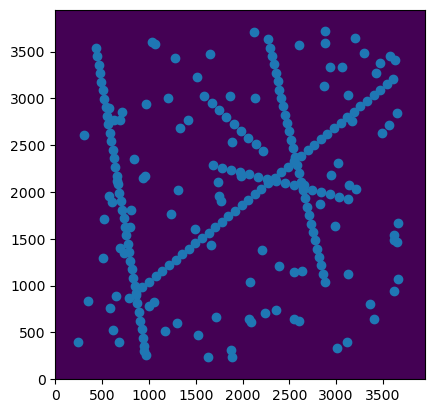

In [18]:
plt.imshow(image, origin="lower")
plt.scatter(x=coords[:, 0], y=coords[:, 1])


In [19]:
# Separate the real nodes from the fake nodes:

real_nodes, fake_nodes = [], []

for idx, node in G.nodes.data():
    if node['label'] > 0:
        real_nodes.append([node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]])
    else:
        fake_nodes.append([node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]])

real_coords = np.array(real_nodes)
fake_coords = np.array(fake_nodes)
real_coords.shape, fake_coords.shape

((133, 2), (100, 2))

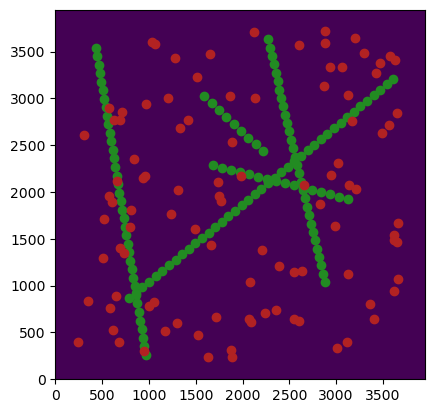

In [20]:
plt.imshow(image, origin="lower")
plt.scatter(x=real_coords[:, 0], y=real_coords[:, 1], color='forestgreen')
plt.scatter(x=fake_coords[:, 0], y=fake_coords[:, 1], color='firebrick')


##### Visualise how the edge weights are distributed:


In [21]:
def plot_node_and_edge_label_distribution(graph: nx.Graph) -> None: 

    real_node_pred = [node['node_prediction'] for _, node in graph.nodes(data=True) if node['label'] > 0]
    fake_node_pred = [node['node_prediction'] for _, node in graph.nodes(data=True) if node['label'] <= 0]

    plt.hist(real_node_pred, color="forestgreen", label=f"Real nodes ({len(real_node_pred)})")
    plt.hist(fake_node_pred, color="firebrick", label=f"Fake nodes ({len(fake_node_pred)})")
    plt.title(f"Distribution of synthetic prediction values in {len(real_node_pred) + len(fake_node_pred)} nodes")
    plt.legend()
    plt.show()



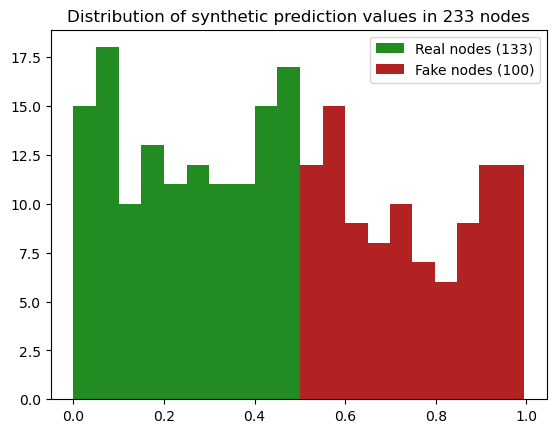

In [22]:
plot_node_and_edge_label_distribution(graph=G)

### Now read the coords of real & fake nodes & color-code the image accordingly:

In [23]:
real_coords.shape

(133, 2)

In [39]:
# def synthesize_image_from_graph(G: nx.Graph, image_value: float, image_shape: tuple[int, int], mask_shape: tuple[int, int], crop_shape: tuple[int, int]):
#     """ Synthesizes a 2D fake image of specified shape with 
#         white patch centres of real nodes (belonging to an object) 
#         and black patch centres of fake nodes (random noisy nodes).
#     """

#     # Create a fake blank image:
#     image = create_blank_image(image_value=image_value, image_shape=image_shape, image_padding=crop_shape)
    
#     # Define patches - grey for object-belonging nodes, black for random noisy nodes:
#     patch_black = np.zeros(shape=mask_shape, dtype=image.dtype)
#     patch_white = np.ones(shape=mask_shape, dtype=image.dtype) * 127
    
#     for _, node in G.nodes.data():
#         coords = node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]
#         st_x, en_x = int(coords[0]) - mask_shape[0] // 2, int(coords[0]) + mask_shape[0] // 2
#         st_y, en_y = int(coords[1]) - mask_shape[1] // 2, int(coords[1]) + mask_shape[1] // 2
        
#         # Paint the image according to the node label:
#         if node['label'] > 0:  # real node with GT = 1
#             image[st_x:en_x, st_y:en_y] = patch_white
#         else:
#             image[st_x:en_x, st_y:en_y] = patch_black

#     return image

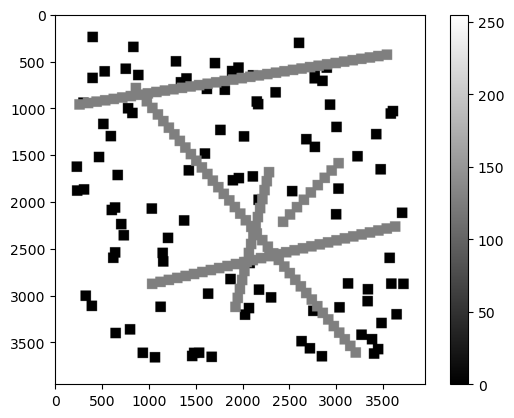

In [47]:
patch_shape = (112, 112)
image = synthesize_image_from_graph(G, image_value=value, image_shape=(scale, scale), mask_shape=MASK_SHAPE, crop_shape=CROP_SHAPE)
plt.imshow(image, cmap="binary_r")
plt.colorbar()
plt.show()

### Visualise a few training patch montages:

In [62]:
# def montage_from_image(G: nx.Graph, image: np.ndarray, crop_shape: tuple[int, int]):

#     crops = [[], []]
#     for _, node in G.nodes.data():
#         coords = node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]
#         st_x, en_x = int(coords[0]) - crop_shape[0] // 2, int(coords[0]) + crop_shape[0] // 2
#         st_y, en_y = int(coords[1]) - crop_shape[1] // 2, int(coords[1]) + crop_shape[1] // 2

#         # Sort crops based on labels:
#         crop = image[st_x:en_x, st_y:en_y]
#         crops[node['label']].append(crop)

#     for c, crop_collection in enumerate(crops):
#         mont = montage(crop_collection[:49], grid_shape=(7, 7))
#         plt.imshow(mont, cmap='binary_r')
#         plt.colorbar()
#         plt.title(f"Montage of patches with 'node_label' = {c}")
#         plt.show()
        

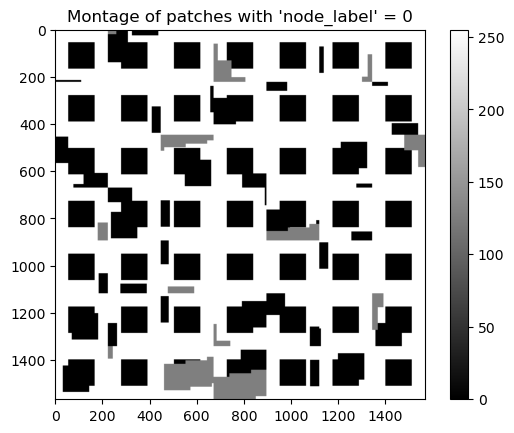

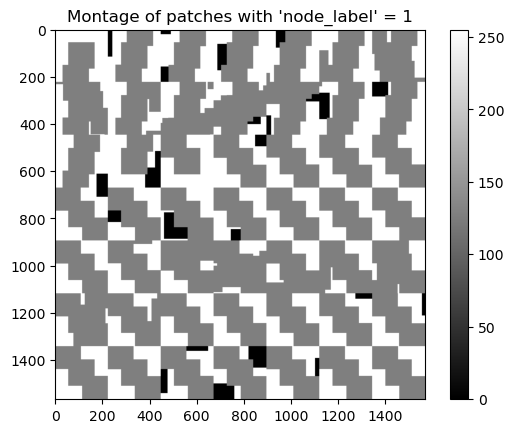

In [63]:
montage_from_image(G, image, crop_shape=CROP_SHAPE)

### Save the image as `mrc` file and the positions of the nodes as `h5` file:

In [64]:
# def save_image_and_nodes_combo(image: np.ndarray, nodes: np.ndarray, image_number: int):

#     save_dr = "/Users/kulicna/Desktop/classifier/data_fake/"
#     save_fn = f"MRC_File_{str(image_number).zfill(3)}.mrc"
#     save_h5 = save_fn.replace("mrc", "h5")

#     SAVE_IMAGE = os.path.join(save_dr, save_fn)
#     SAVE_NODES = os.path.join(save_dr, save_h5)

#     with mrcfile.new(SAVE_IMAGE, overwrite=True) as mrc:
#         mrc.set_data(image)

#     coords_df = pd.DataFrame(nodes, columns=["x", "y"])
#     coords_df.to_hdf(SAVE_NODES, key='df', mode='w')


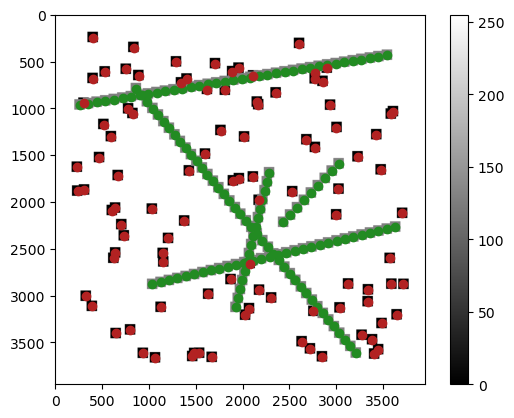

In [65]:
# Plot the image & nodes together correspondingly:

plt.imshow(image, cmap='binary_r')
plt.colorbar()
plt.scatter(x=real_coords[:, 1], y=real_coords[:, 0], color='forestgreen')
plt.scatter(x=fake_coords[:, 1], y=fake_coords[:, 0], color='firebrick')
plt.show()

In [8]:
image_number = 5


In [ ]:
save_image_and_nodes_combo(image=image.T, nodes=coords, image_number=image_number)

### Re-open the mrc file:

In [9]:
save_dr = "/Users/kulicna/Desktop/classifier/data_fake/infer"
save_fn = f"MRC_File_{str(image_number).zfill(3)}.mrc"
SAVE_IMAGE = os.path.join(save_dr, save_fn)
SAVE_IMAGE, os.path.isfile(SAVE_IMAGE)

('/Users/kulicna/Desktop/classifier/data_fake/infer/MRC_File_005.mrc', True)

In [10]:
with mrcfile.open(SAVE_IMAGE, "r") as mrc:
    # image_data = mrc.data.astype(int) # works
    image_data = mrc.data


In [11]:
image_data.shape, image_data.dtype

((3948, 3948), dtype('<f4'))

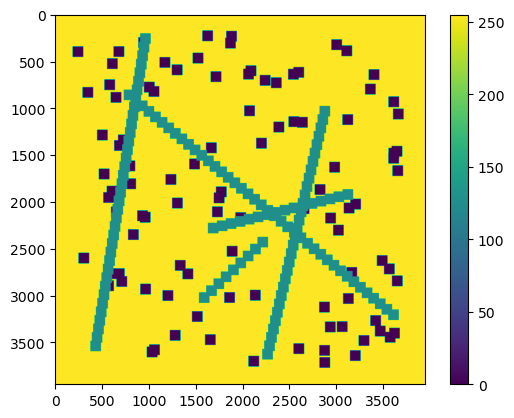

In [12]:
plt.imshow(image_data.astype(int))
plt.colorbar()
plt.show()

### Show annotation:

In [87]:
SAVE_GRACE = SAVE_IMAGE.replace(".mrc", ".grace/annotation.npz")
SAVE_GRACE, os.path.isfile(SAVE_GRACE)

('/Users/kulicna/Desktop/classifier/data_fake/infer/MRC_File_005.grace/annotation.npz',
 True)

In [88]:
loaded = np.load(SAVE_GRACE)

for key, value in loaded.items():
    print (key, value.shape)

annotation (3948, 3948)


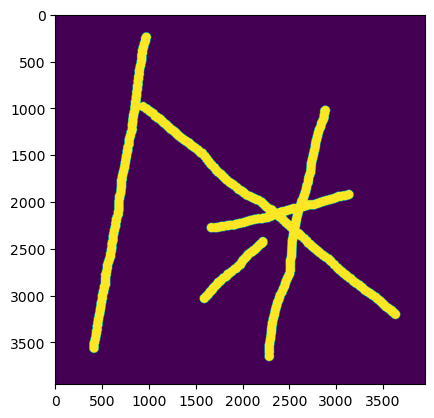

In [89]:
plt.imshow(value)

### Done!